In [2]:
# packages and etc etc 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats

df = pd.read_pickle('combined_df.pkl')

focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUG/NARCOTIC', 
                   'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY'])

df['Date'] = pd.to_datetime(df['Date'])
focuscrime_df = df[df['Category'].isin(focuscrimes)].copy()
focuscrime_df['Year'] = focuscrime_df['Date'].dt.year


In [3]:
print(focuscrime_df.columns)

Index(['Category', 'Date', 'Time', 'PdDistrict', 'X', 'Y', 'Descript', 'Year'], dtype='object')


#### Jitter plot

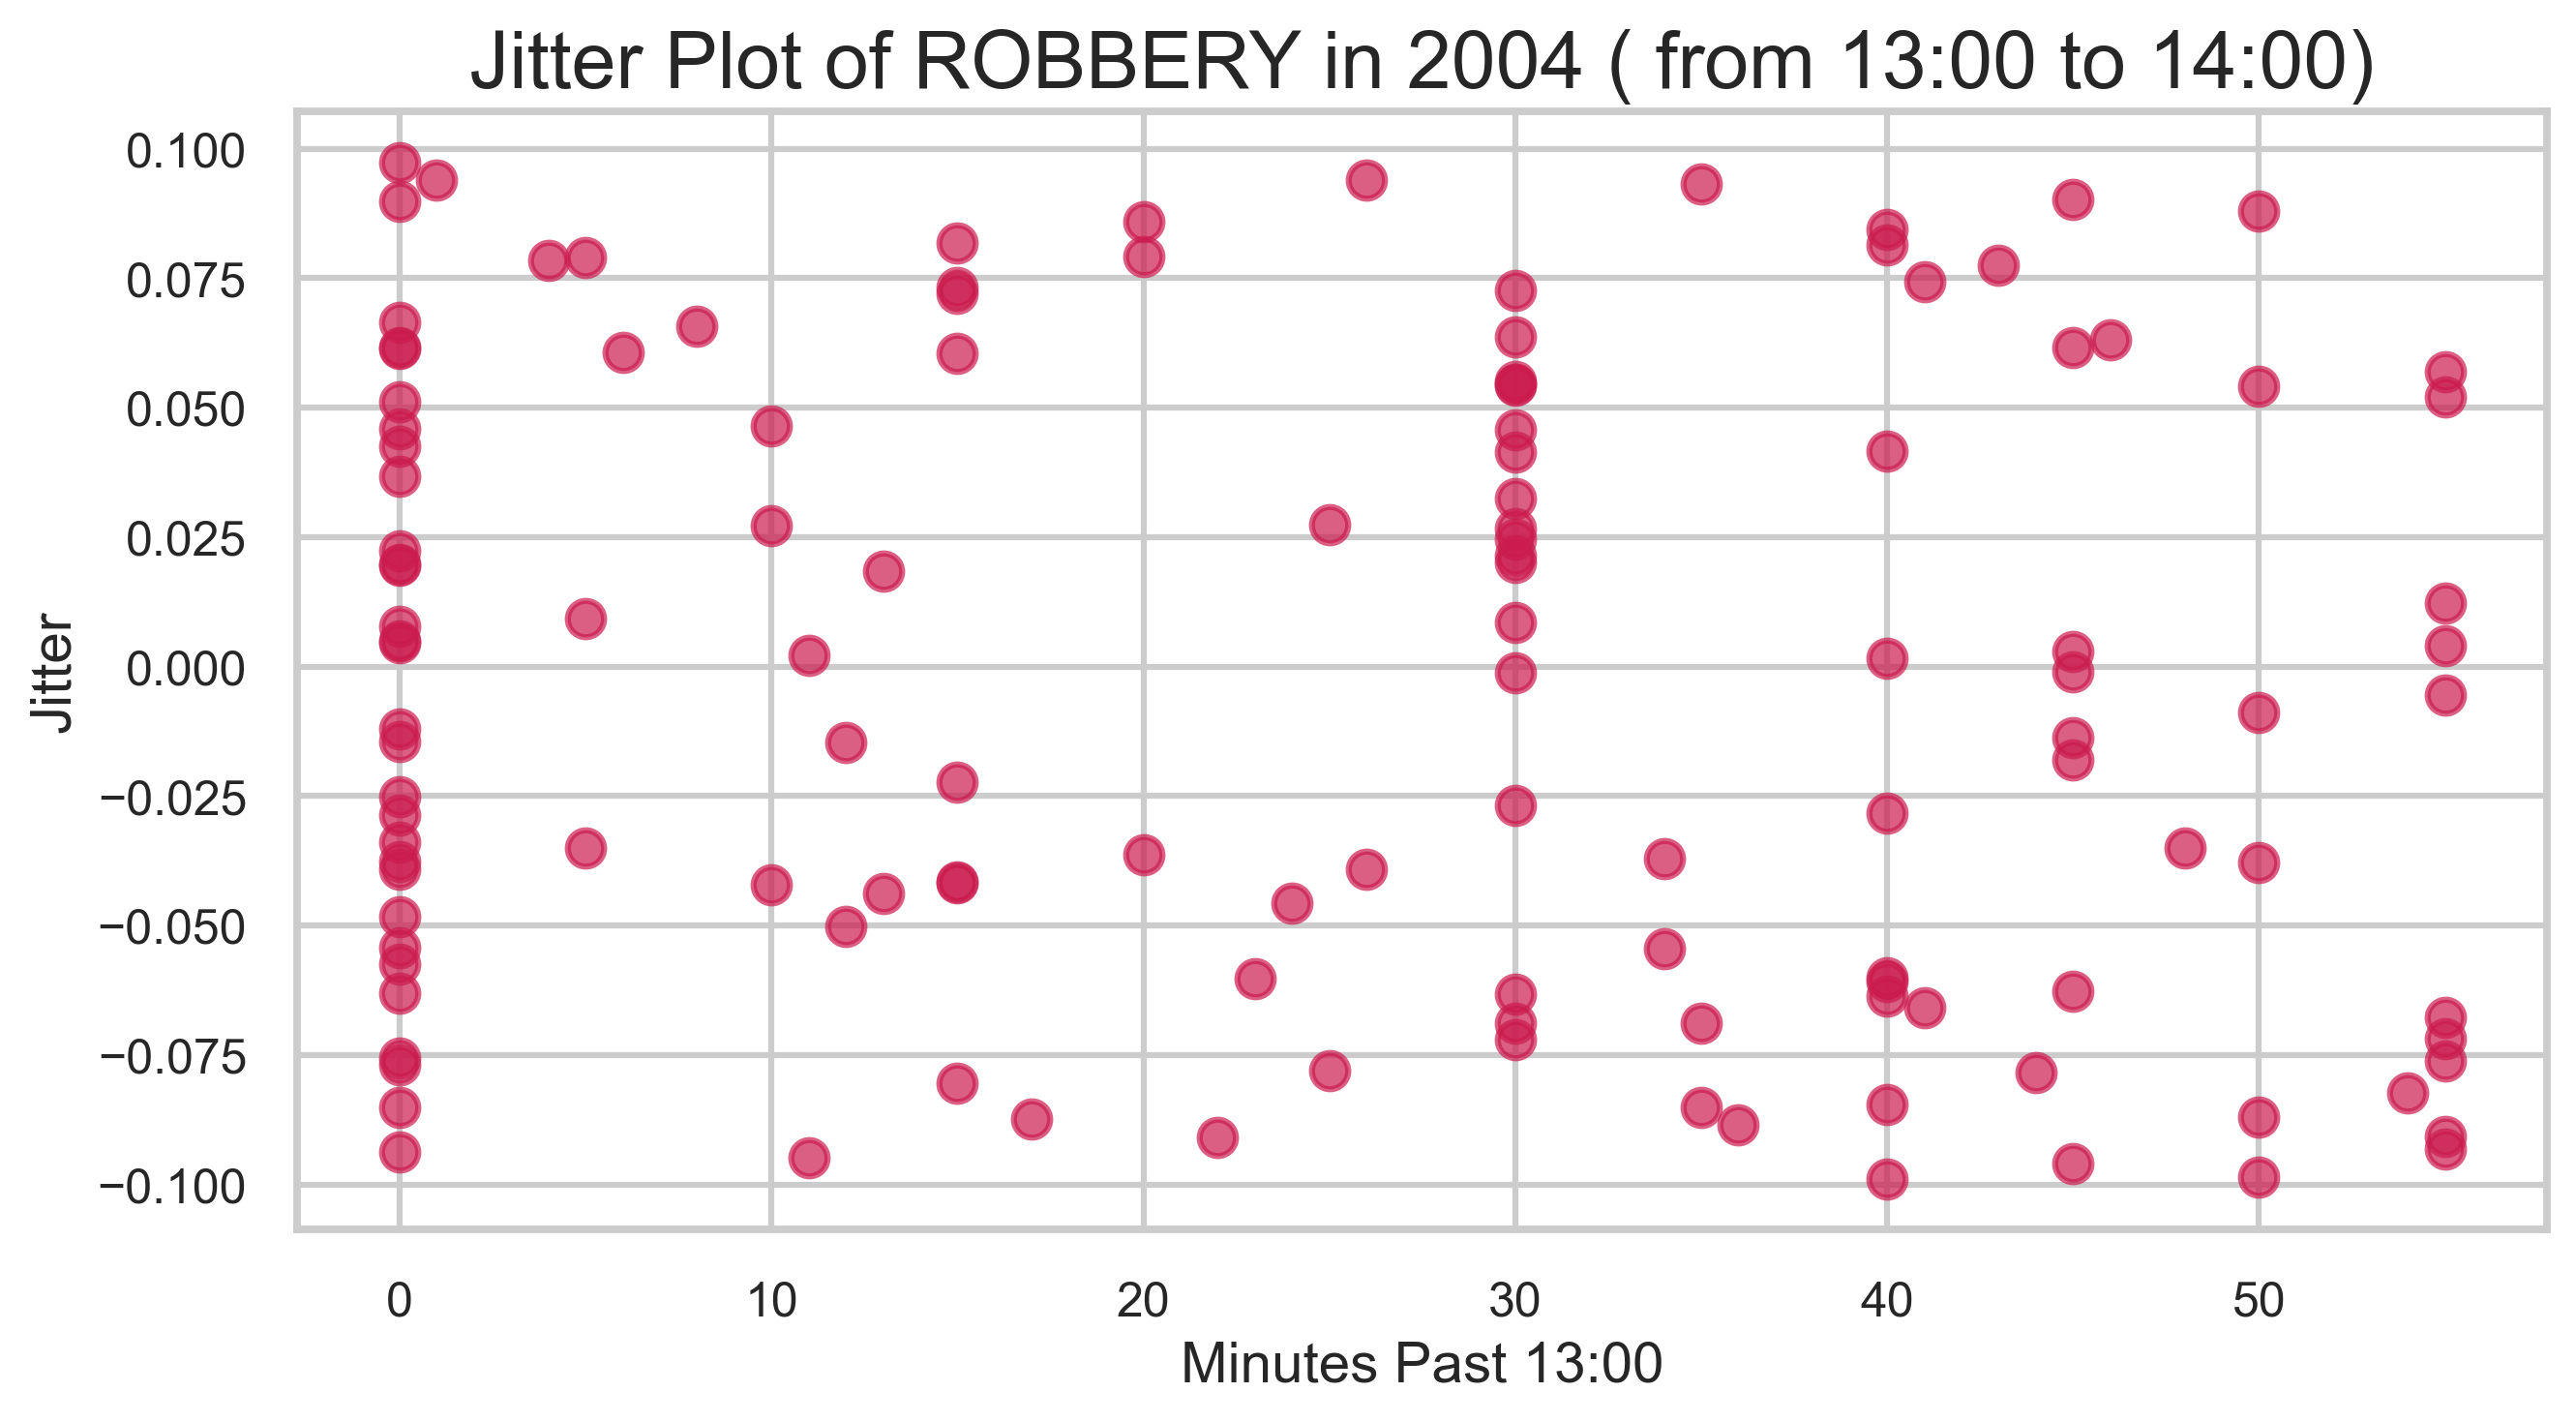

In [4]:
# High-resolution rendering
plt.rcParams['figure.dpi'] = 300

# Seaborn context and style for a talk-like, publication-quality look
sns.set_context("talk", font_scale=1.1)
sns.set_style("whitegrid")

# Global font and axis settings
plt.rcParams.update({
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Define the single category and time filters
crime_type = "ROBBERY"
start_date = "2004-01-01"
end_date = "2005-01-01"
hour_window = (13, 14)

# little conversion
df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"])

# filter according to conditions
filtered_df = df[
    (df["Category"] == crime_type) & 
    (df["datetime"] >= start_date) & 
    (df["datetime"] <= end_date) & 
    (df["datetime"].dt.hour >= hour_window[0]) & 
    (df["datetime"].dt.hour < hour_window[1])
].copy()

# Assign jitter
np.random.seed(42)
filtered_df["jitter"] = np.random.uniform(-0.1, 0.1, len(filtered_df))

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_df["datetime"].dt.minute, filtered_df["jitter"], alpha=0.7, 
            color=sns.color_palette("rocket", n_colors=5)[2])
plt.xlabel("Minutes Past 13:00")
plt.ylabel("Jitter")
plt.title(f"Jitter Plot of {crime_type} in 2004 ( from {hour_window[0]}:00 to {hour_window[1]}:00)")
plt.grid(True)

plt.show()


From this plot we see that most of the crimes seem to occur at the full or half our (i.e. at 13.00, 13.30 or 14.00). This confirms the suspicion from the exercises that the policemen are a little sloppy when it comes to recording the time. It appears that they round up to the nearest half hour. 

#### Histograms

For this section, we have chosen the focus crimes to be one geographically centered crime and one that is more spread out. For the centered crime, we have chosen prostitution, as this generally tends to happen within cities and even on specific streets. For the geographically spread out crime, we have chosen vehicle theft, as this can happen anywhere. 

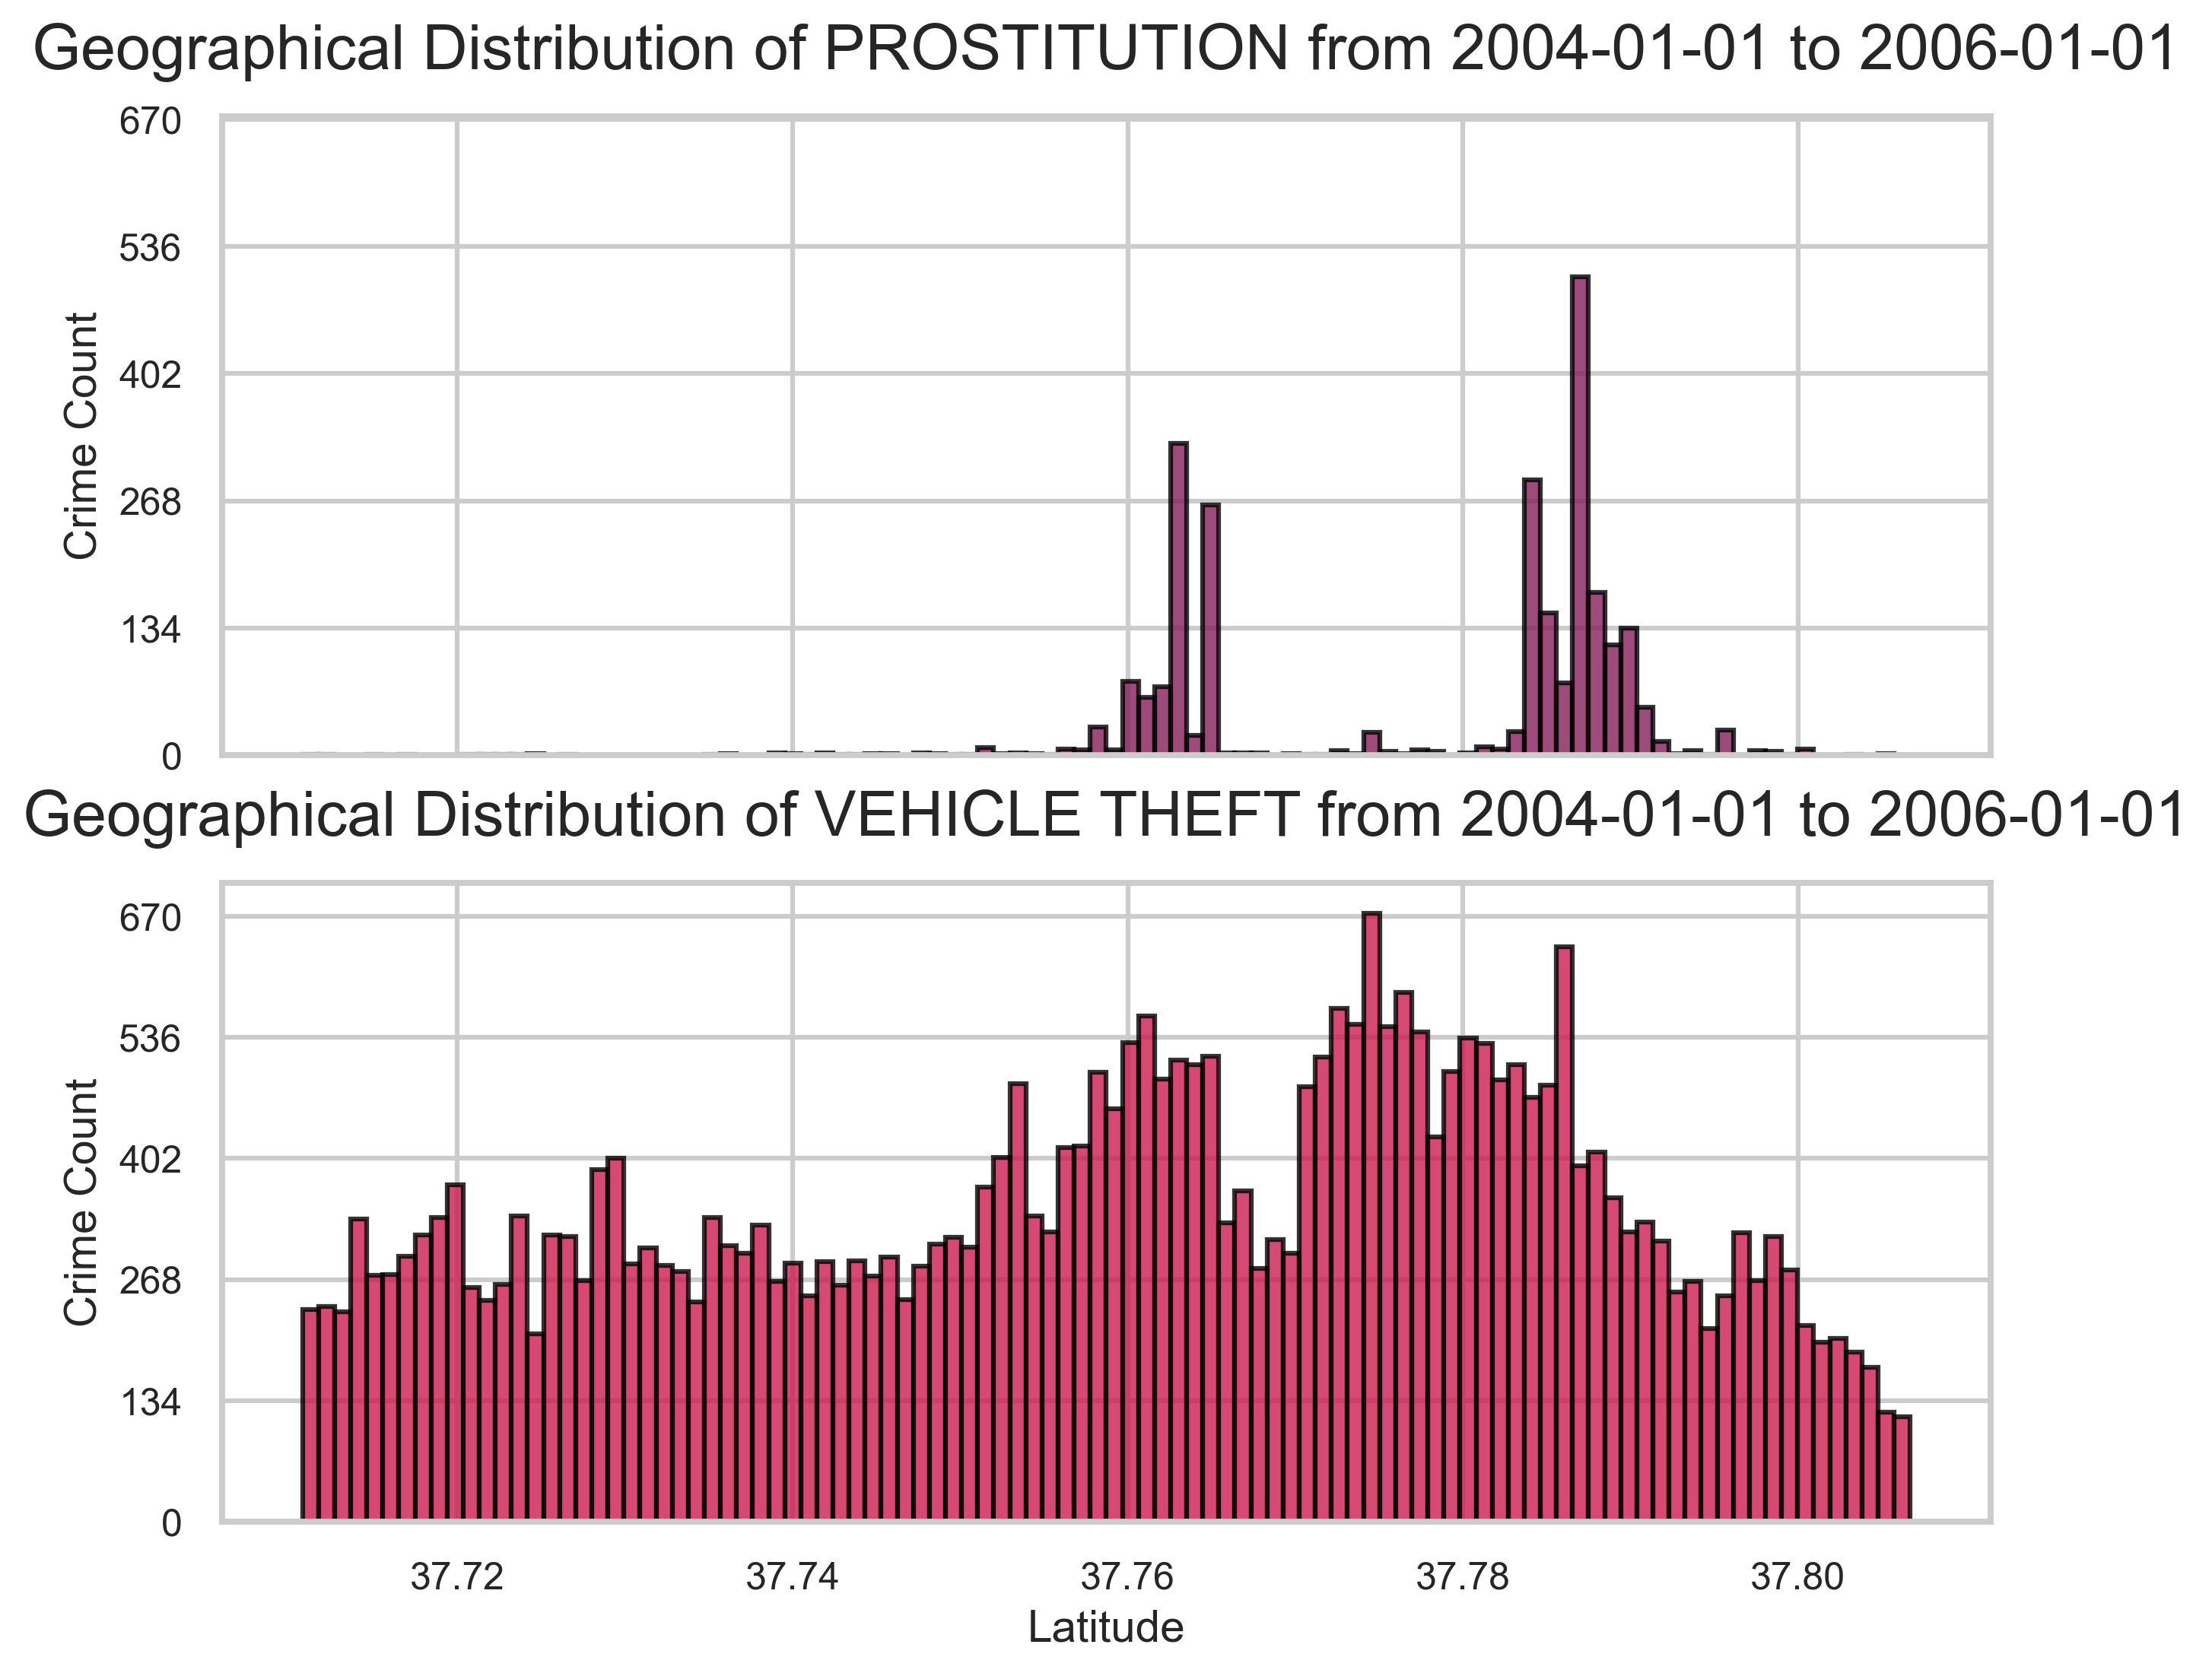

In [5]:
crime_type_1 = "PROSTITUTION"
crime_type_2 = "VEHICLE THEFT"

time_range = ("2004-01-01", "2006-01-01")  

filtered_df_prost = df[
    (df["Category"] == crime_type_1) &
    (df["Date"] >= time_range[0]) &
    (df["Date"] <= time_range[1])
].copy()

filtered_df_VT = df[
    (df["Category"] == crime_type_2) &
    (df["Date"] >= time_range[0]) &
    (df["Date"] <= time_range[1])
].copy()

# Get latitudes
latitudes_1 = filtered_df_prost["Y"].dropna()
latitudes_2 = filtered_df_VT["Y"].dropna()

# Bin time
num_bins = 100
lat_min, lat_max = np.percentile(df["Y"].dropna(), [1, 99])
bins = np.linspace(lat_min, lat_max, num_bins + 1)

# Histograms after bin time
hist_1, _ = np.histogram(latitudes_1, bins=bins)
hist_2, _ = np.histogram(latitudes_2, bins=bins)

# get same y axis

y_max = max(hist_1.max(), hist_2.max())

# Plot histograms
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Histogram for crime type 1
axes[0].bar(bins[:-1], hist_1, width=np.diff(bins), color=sns.color_palette("rocket", n_colors=5)[1], edgecolor="black", alpha=0.8)
axes[0].set_ylabel("Crime Count")
axes[0].set_title(f"Geographical Distribution of {crime_type_1} from {time_range[0]} to {time_range[1]}", pad=15)
axes[0].set_ylim(0, y_max) 

# Histogram for crime type 2
axes[1].bar(bins[:-1], hist_2, width=np.diff(bins), color=sns.color_palette("rocket", n_colors=5)[2], edgecolor="black", alpha=0.8)
axes[1].set_xlabel("Latitude")
axes[1].set_ylabel("Crime Count")
axes[1].set_title(f"Geographical Distribution of {crime_type_2} from {time_range[0]} to {time_range[1]}", pad=15)
axes[0].set_ylim(0, y_max) 

# more fixing the y axis 
yticks = np.arange(0, y_max + 1, y_max // 5)
axes[0].set_yticks(yticks)
axes[1].set_yticks(yticks)

plt.show()


Now we move on to the KDE plots from the book. Here, we wjasnofadæf

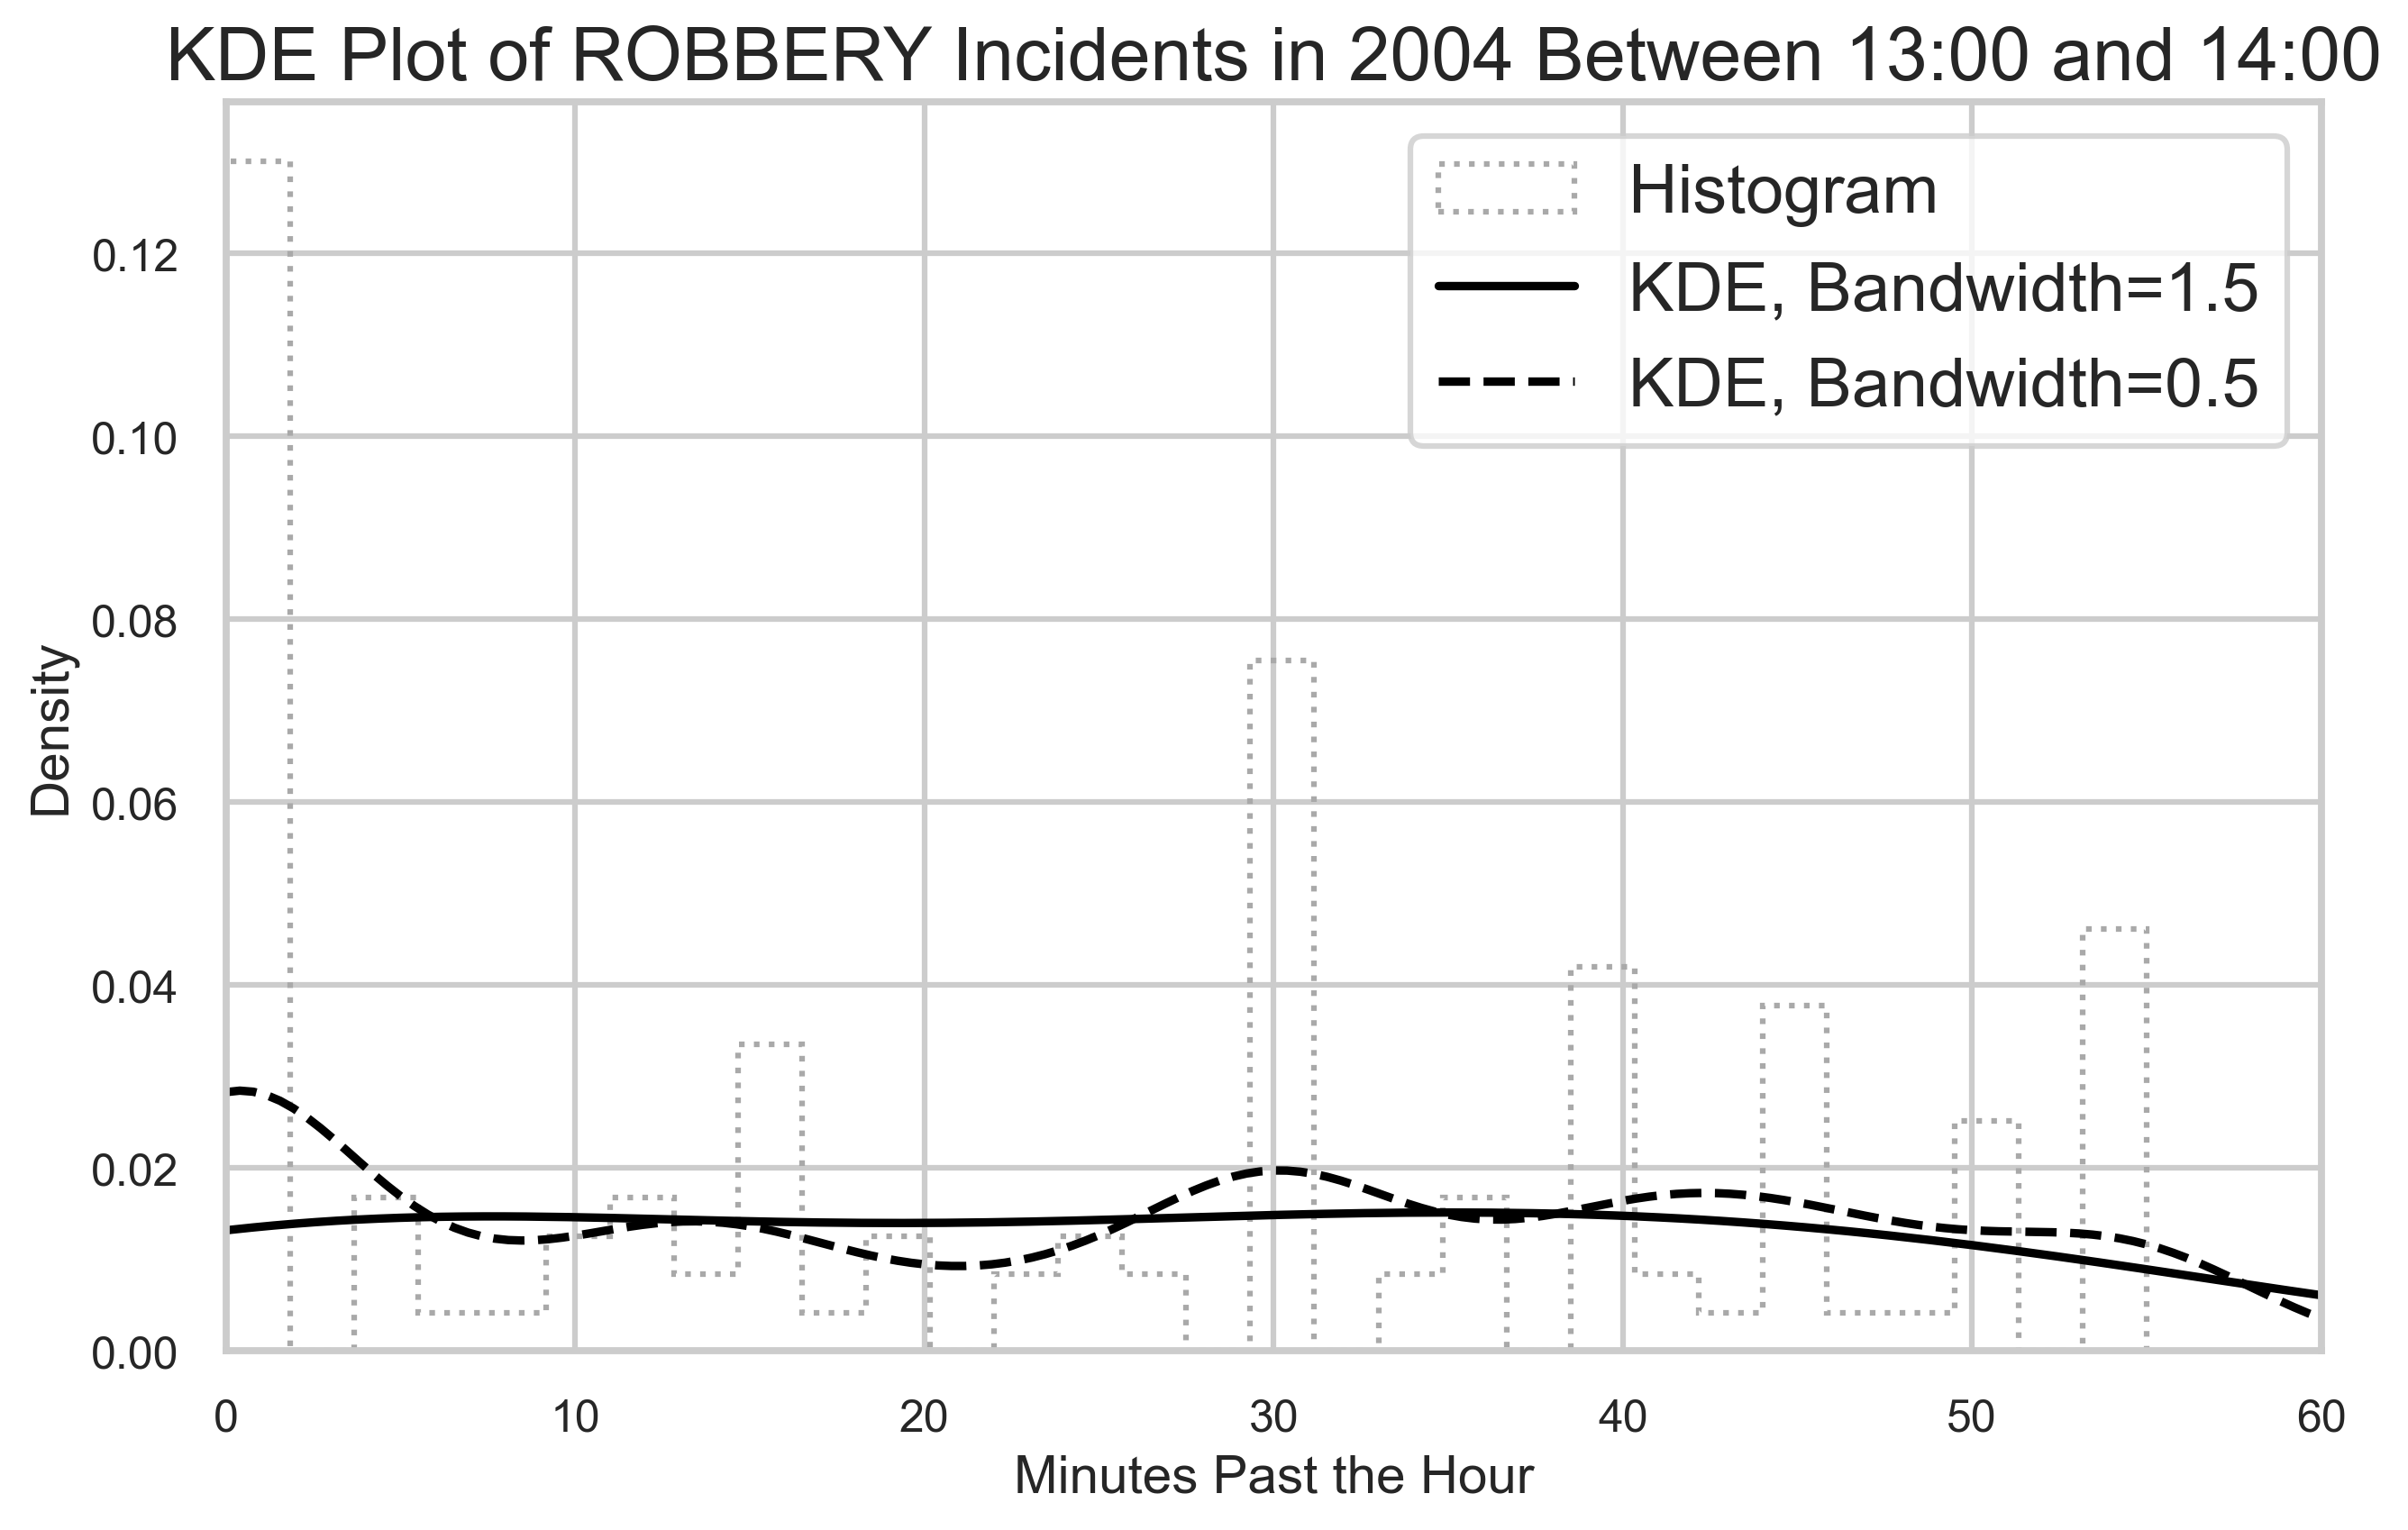

In [6]:

# We have already defined this filter in the jitterplot above, but we redefine it here in case we run this cell independently or want to look at a different subset of data
crime_type = "ROBBERY"
start_date = "2004-01-01"
end_date = "2005-01-01"
hour_window = (13, 14)

# little conversion
df["datetime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"])

# filter according to conditions
filtered_df = df[
    (df["Category"] == crime_type) & 
    (df["datetime"] >= start_date) & 
    (df["datetime"] <= end_date) & 
    (df["datetime"].dt.hour >= hour_window[0]) & 
    (df["datetime"].dt.hour < hour_window[1])
].copy()

kde_data = filtered_df["datetime"].dt.minute

# start figure
plt.figure(figsize=(10, 6))

# Histogram 
counts, bins, _ = plt.hist(kde_data, bins=30, density=True, color="darkgray", histtype="step", linestyle="dotted", label="Histogram")

# Doing the different bandwidth thing from the reference figure
sns.kdeplot(kde_data, bw_adjust=1.5, color="black", linestyle="solid", label="KDE, Bandwidth=1.5")
sns.kdeplot(kde_data, bw_adjust=0.5, color="black", linestyle="dashed", label="KDE, Bandwidth=0.5")

# Labels & title
plt.xlabel("Minutes Past the Hour")
plt.ylabel("Density")
plt.title(f"KDE Plot of {crime_type} Incidents in 2004 Between {hour_window[0]}:00 and {hour_window[1]}:00")
plt.legend()
plt.xlim(0, 60)

plt.show()


Like in the exercises, we can take a subset of this data and plot it in a KDE to see the weaknesses of this type of plot: 

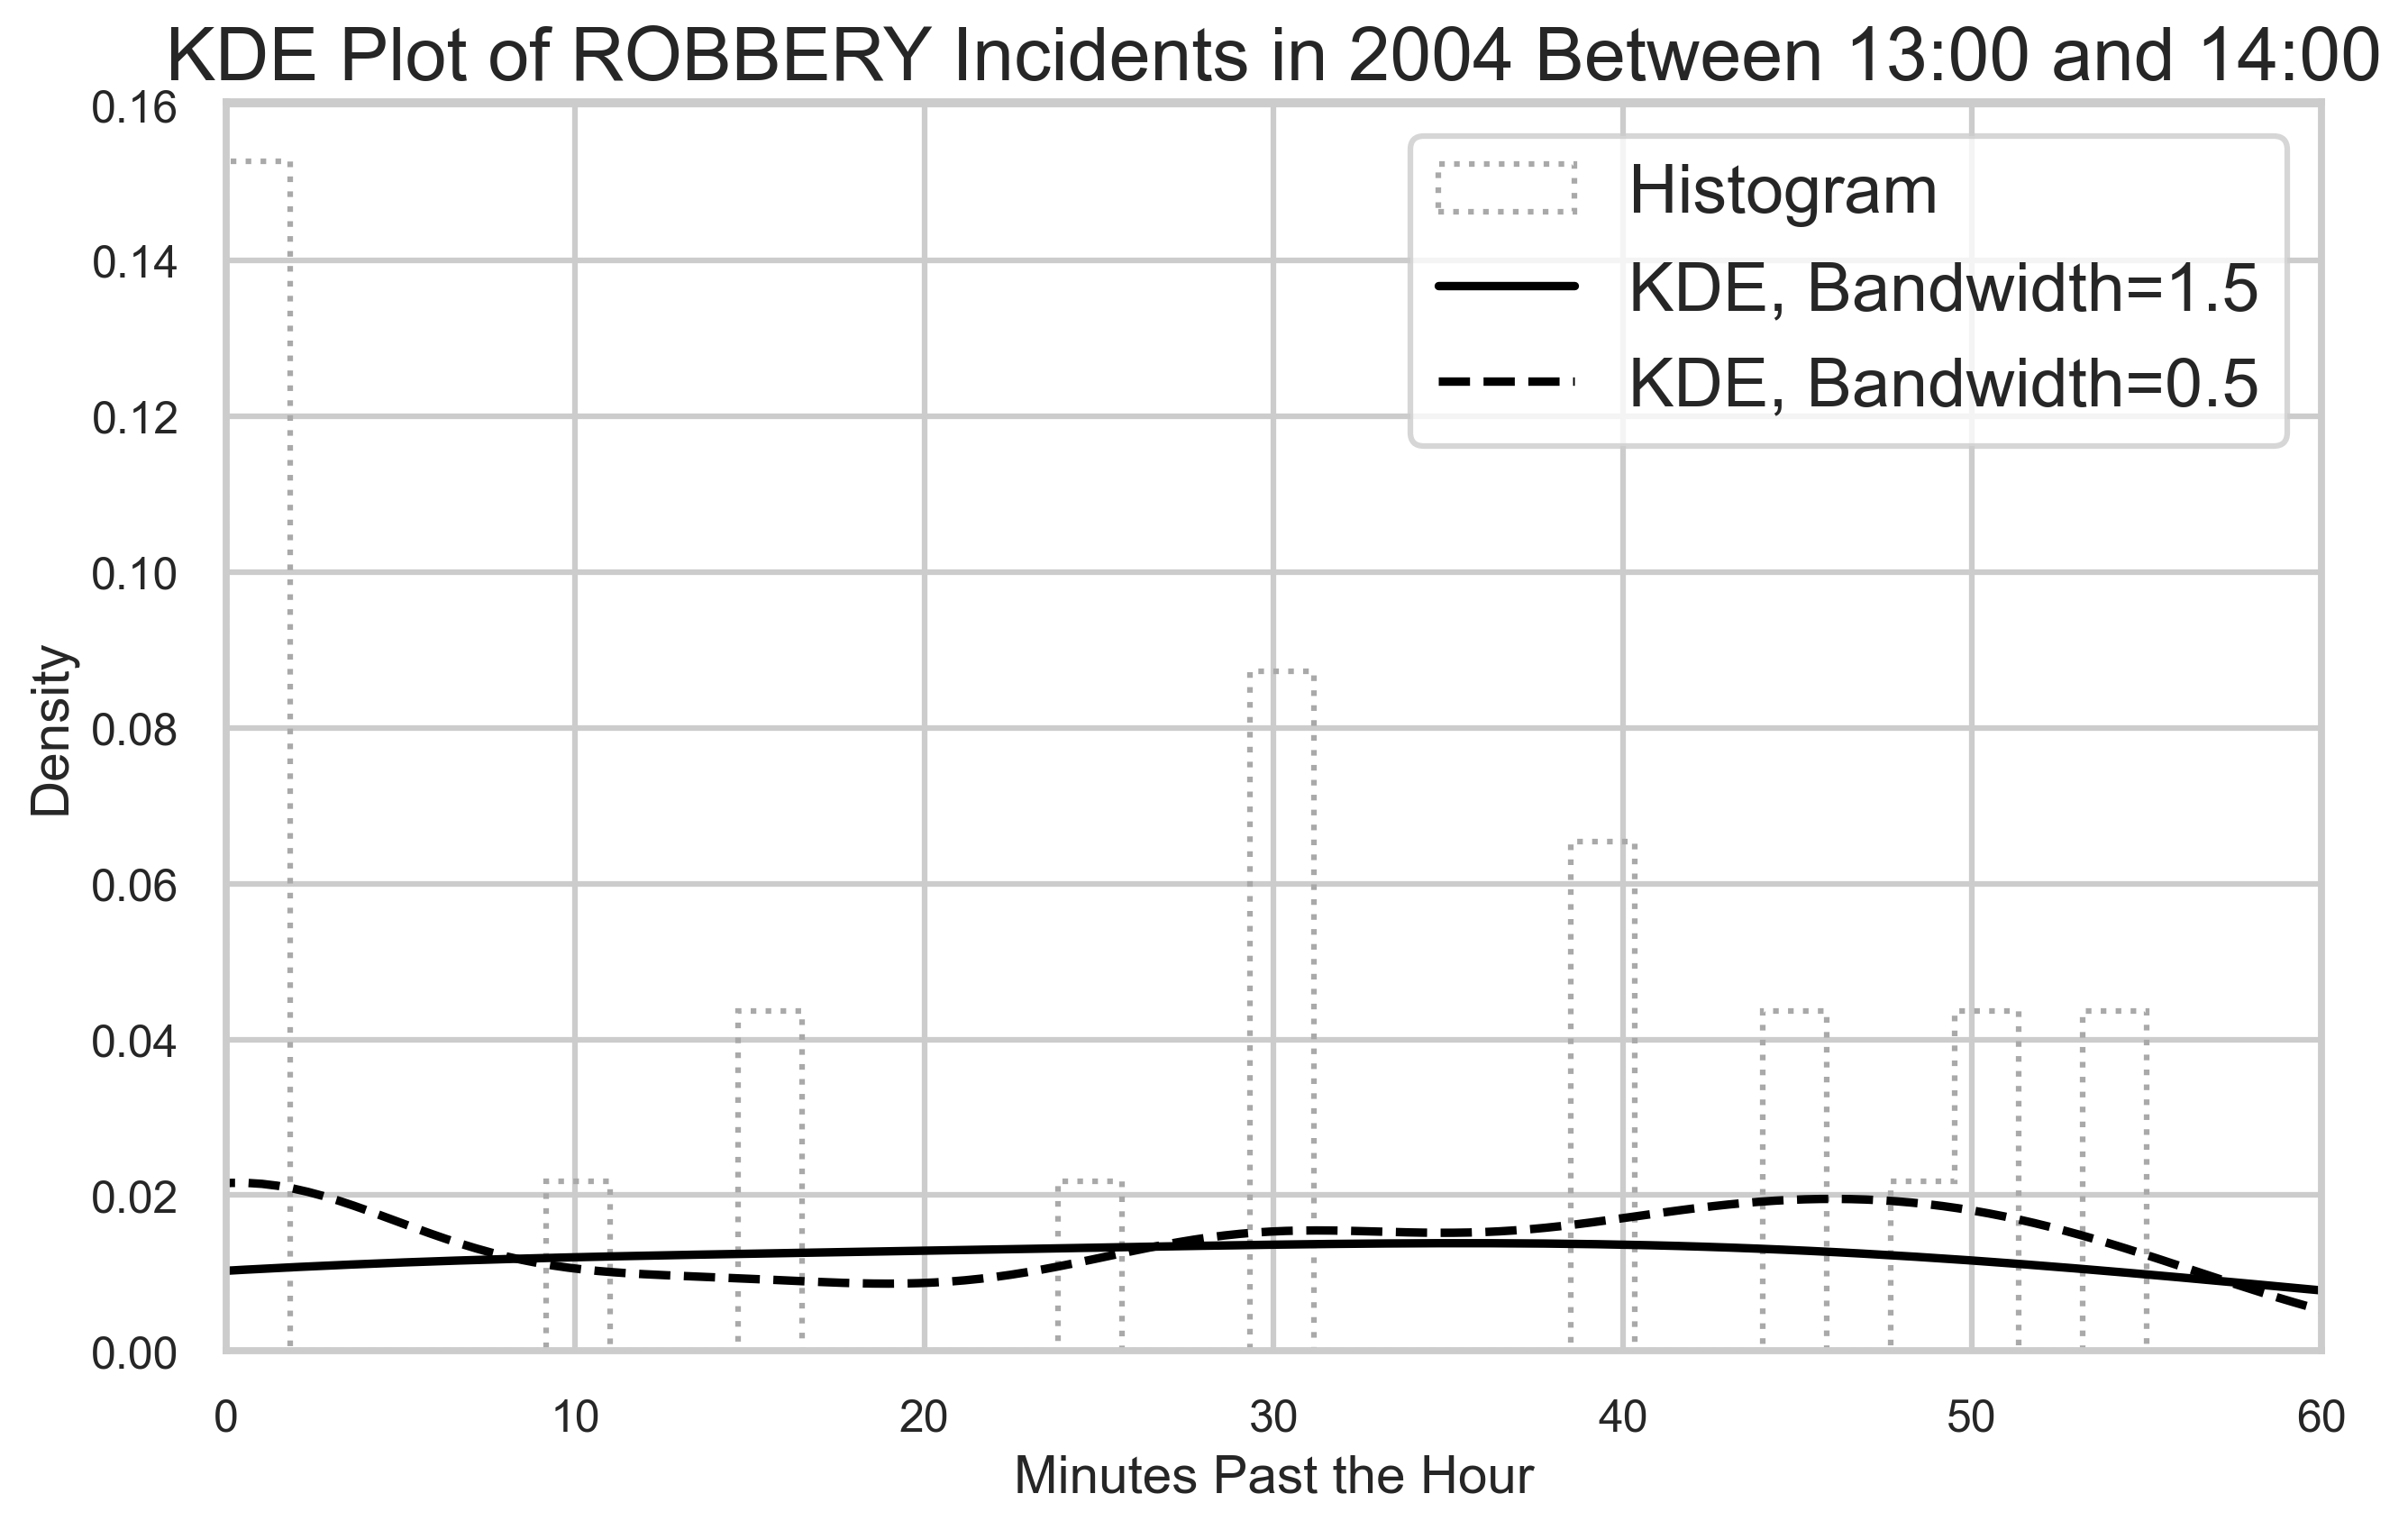

In [7]:
import random

# Now we grab some random data points and do the exact same thing

# Ensure we have at least 25 data points before sampling
if len(kde_data) < 25:
    raise ValueError("Not enough data points to sample 25 unique values. Increase dataset size.")

# Select 25 random timepoints from the previously used dataset
random_sample = random.sample(list(kde_data), 25)

# start figure
plt.figure(figsize=(10, 6))

# Histogram 
counts, bins, _ = plt.hist(random_sample, bins=30, density=True, color="darkgray", histtype="step", linestyle="dotted", label="Histogram")

# Doing the different bandwidth thing from the reference figure
sns.kdeplot(random_sample, bw_adjust=1.5, color="black", linestyle="solid", label="KDE, Bandwidth=1.5")
sns.kdeplot(random_sample, bw_adjust=0.5, color="black", linestyle="dashed", label="KDE, Bandwidth=0.5")

# Labels & title
plt.xlabel("Minutes Past the Hour")
plt.ylabel("Density")
plt.title(f"KDE Plot of {crime_type} Incidents in 2004 Between {hour_window[0]}:00 and {hour_window[1]}:00")
plt.legend()
plt.xlim(0, 60)

plt.show()


From this, we see that KDE plots are not entirely reliable, as this subset shows....

#### Part 2

In part 2 of the exercises from week 3, we were asked to recreate some plots from DAOST. The first of these is a set of probability plots of the latitude data from the previous exercise. 

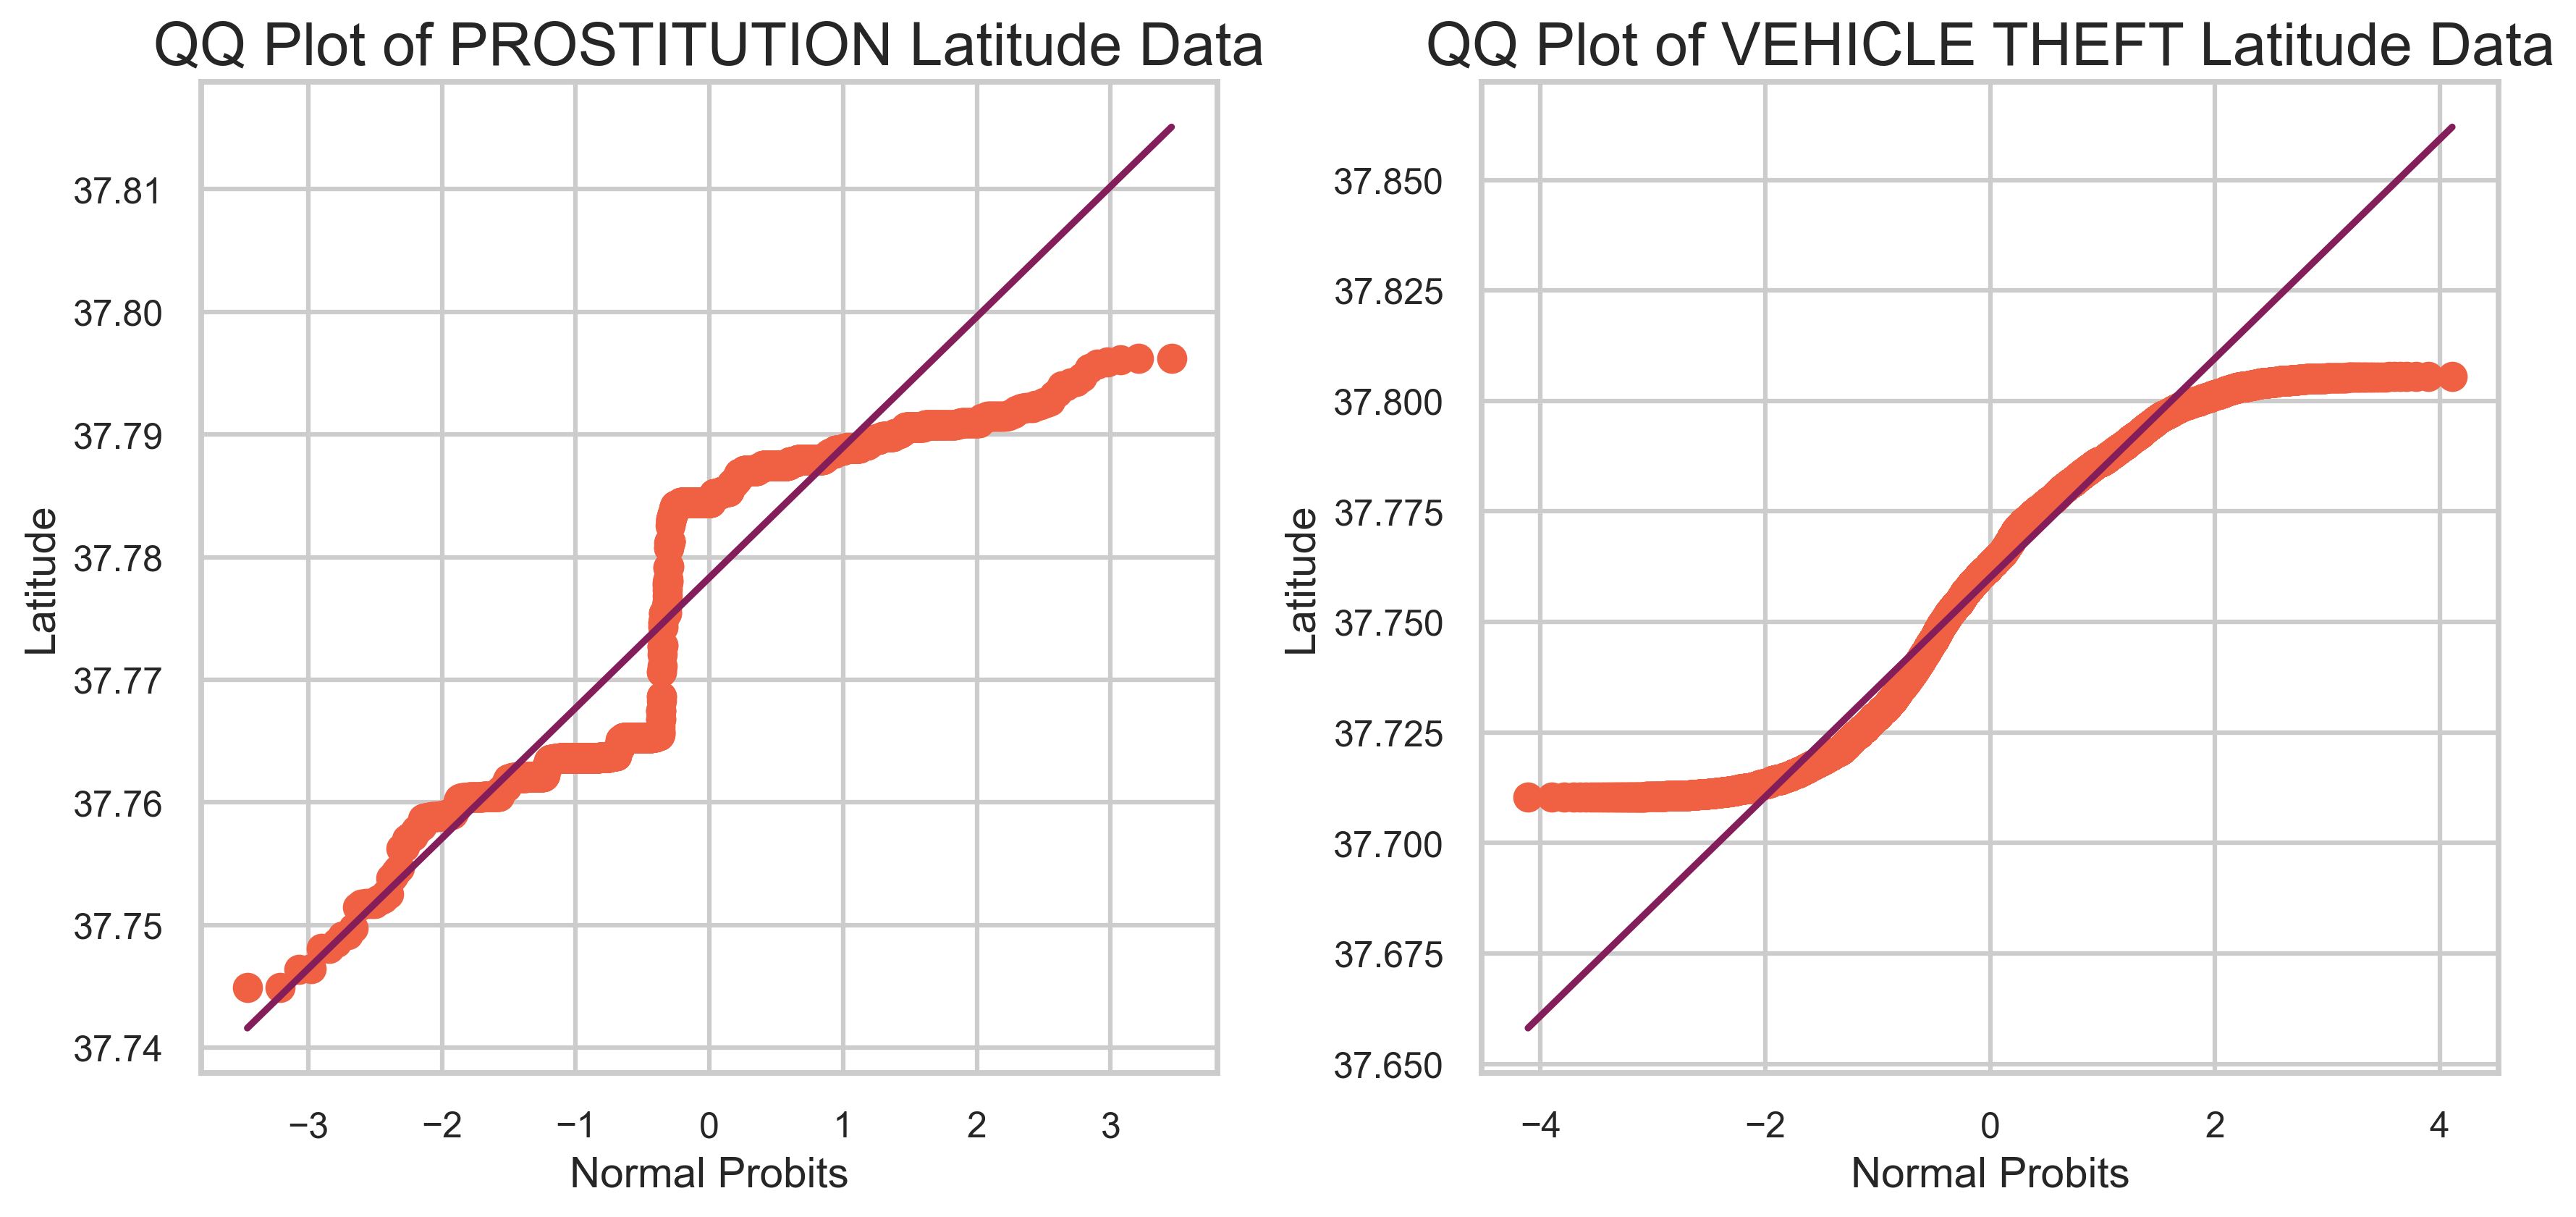

In [20]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# no outliers 
latitudes_1_filtered = latitudes_1[(latitudes_1 > latitudes_1.quantile(0.01)) & (latitudes_1 < latitudes_1.quantile(0.99))]
latitudes_2_filtered = latitudes_2[(latitudes_2 > latitudes_2.quantile(0.01)) & (latitudes_2 < latitudes_2.quantile(0.99))]

# color time
rocket_colors = sns.color_palette("rocket", 5) 
color_1 = rocket_colors[1] 
color_2 = rocket_colors[3] 

# subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plot for crime 1
res_1 = stats.probplot(latitudes_1_filtered, dist="norm", plot=axes[0])
axes[0].get_lines()[1].set_color(color_1)
axes[0].get_lines()[0].set_markerfacecolor(color_2)
axes[0].get_lines()[0].set_markeredgecolor(color_2)
axes[0].set_xlabel("Normal Probits")
axes[0].set_ylabel("Latitude")
axes[0].set_title(f"QQ Plot of {crime_type_1} Latitude Data")

# plot for crime 2
res_2 = stats.probplot(latitudes_2_filtered, dist="norm", plot=axes[1])
axes[1].get_lines()[1].set_color(color_1)
axes[1].get_lines()[0].set_markerfacecolor(color_2)
axes[1].get_lines()[0].set_markeredgecolor(color_2)
axes[1].set_xlabel("Normal Probits")
axes[1].set_ylabel("Latitude")
axes[1].set_title(f"QQ Plot of {crime_type_2} Latitude Data")

# show 
plt.tight_layout()
plt.show()


The prostitution plot looks a lot more jaggered than the vehicle theft plot, which makes sense considering their geographical distribution. 

Now we move on to a bar graph which depicts the crime frequencies per day:

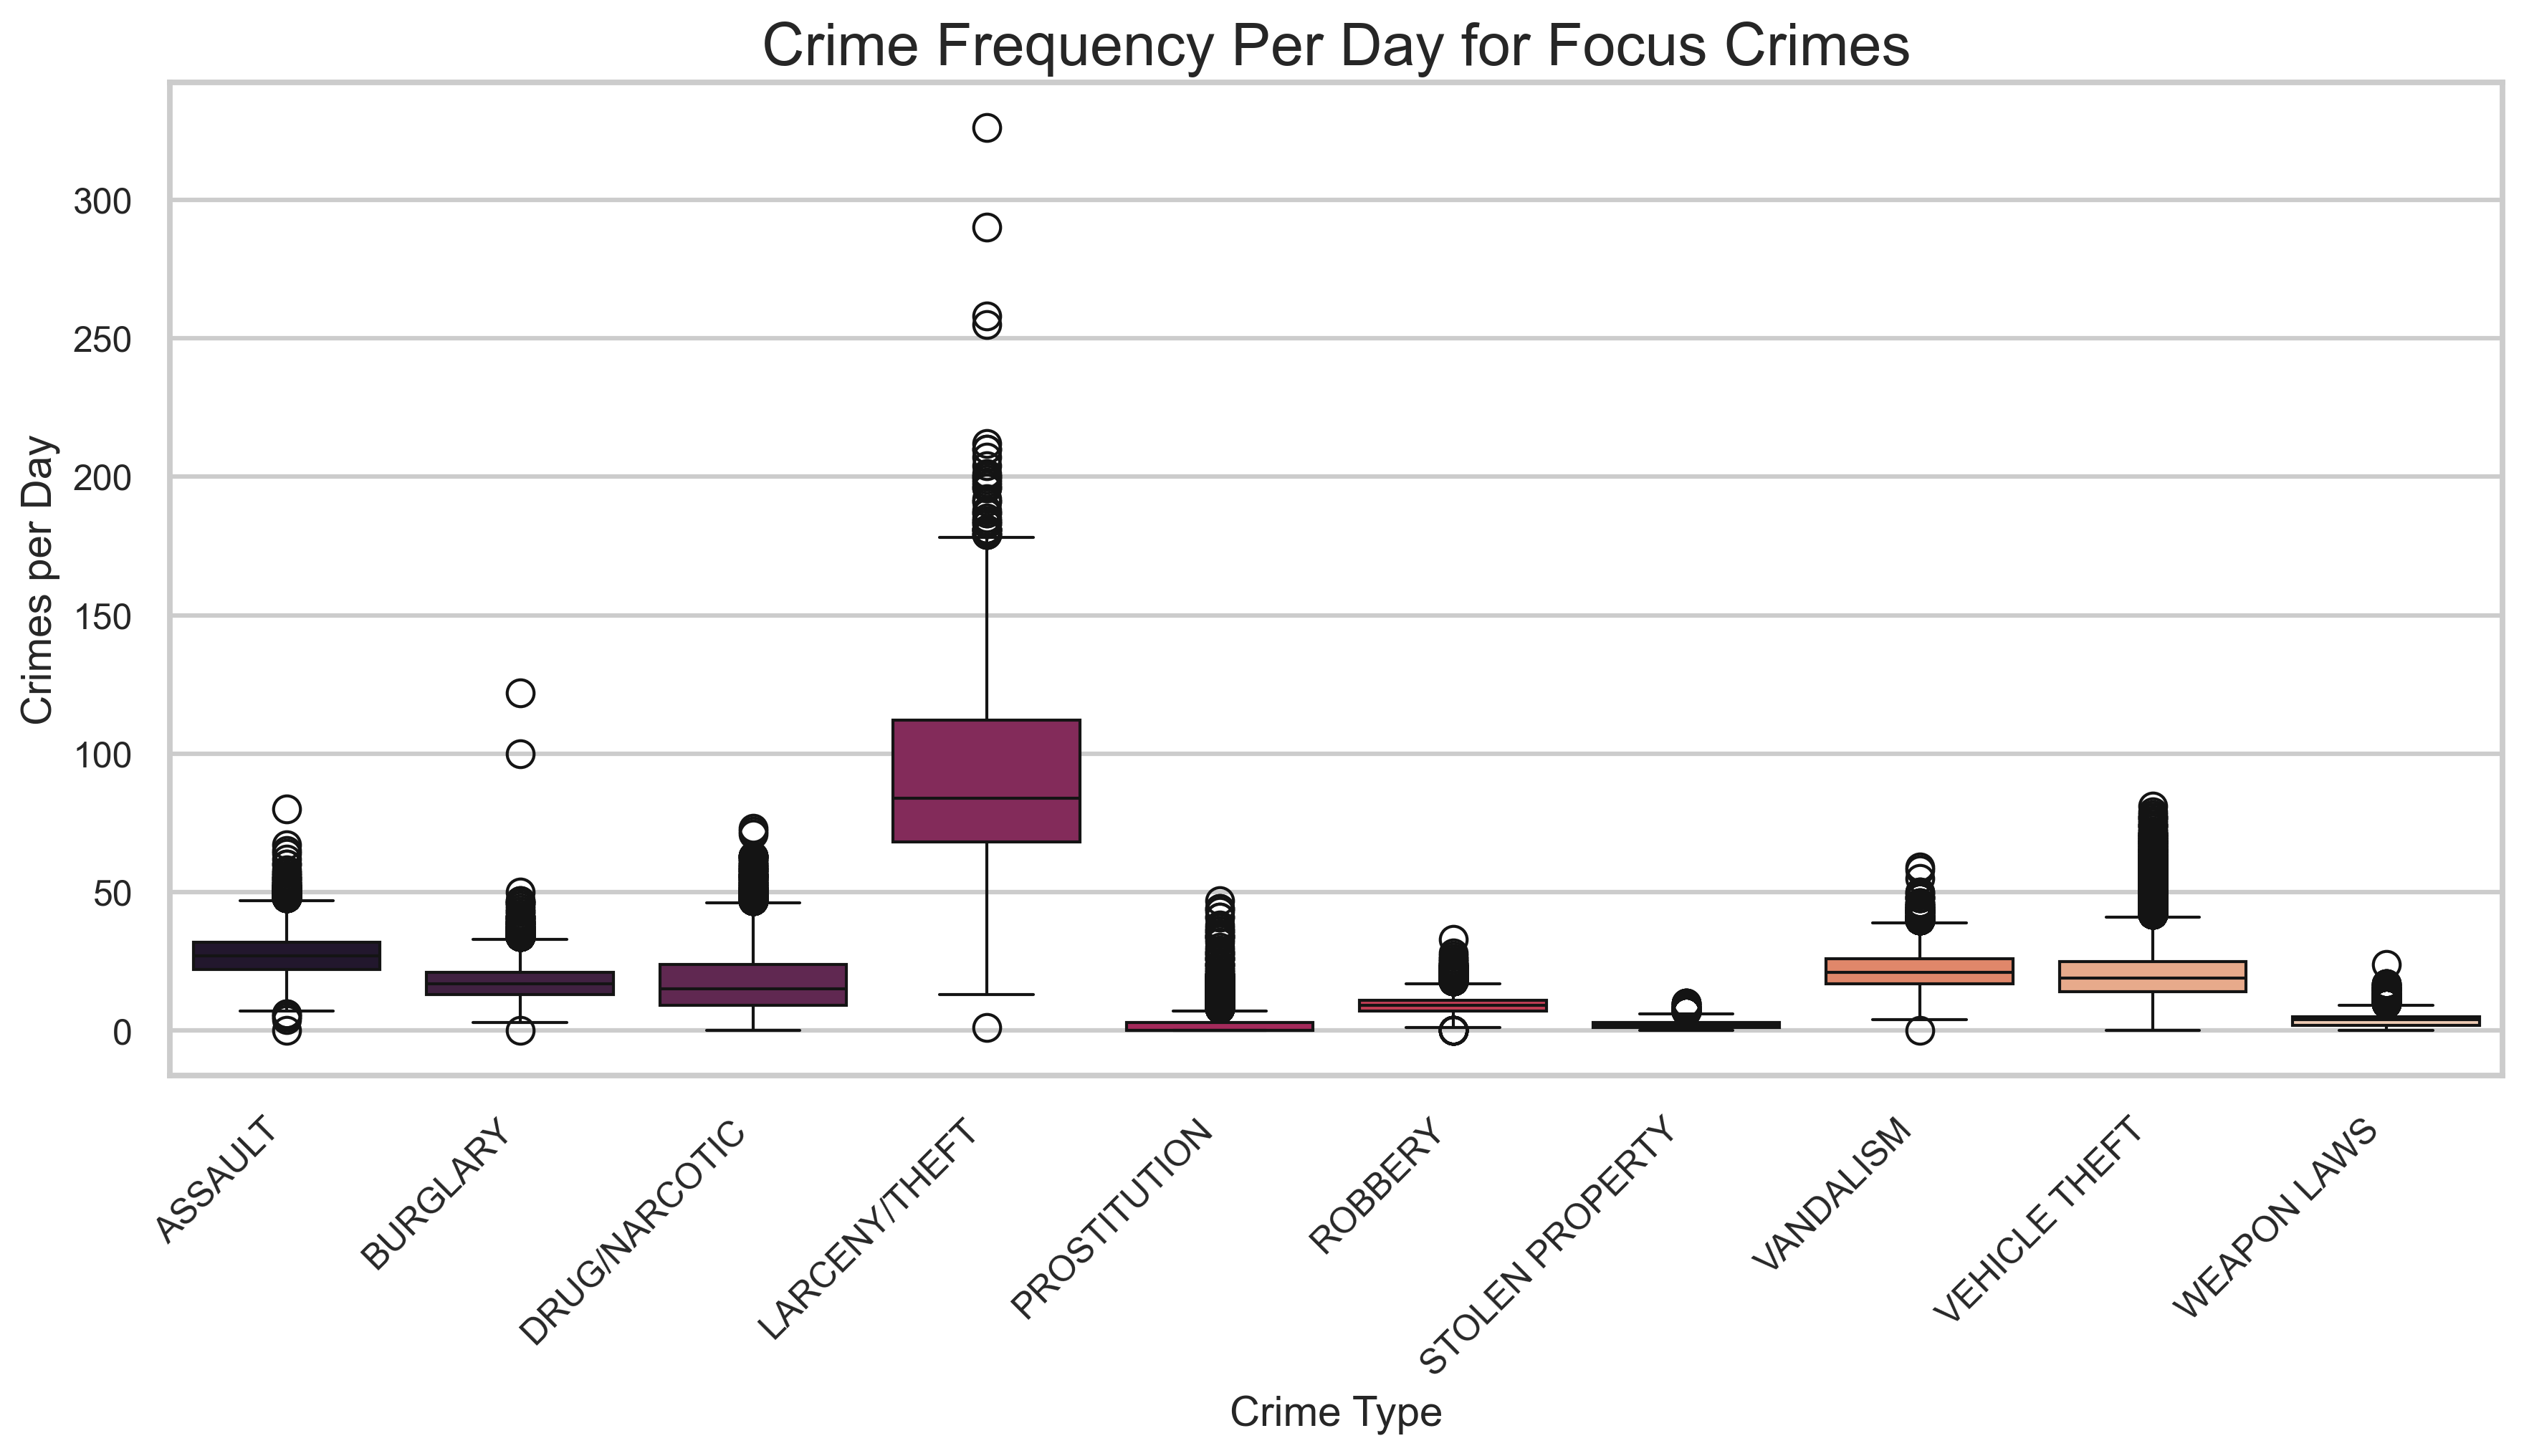

In [9]:
# filter and get counts
crime_counts = df[df["Category"].isin(focuscrimes)]
crime_counts = crime_counts.groupby(["Date", "Category"]).size().reset_index(name="count")

# pivot for boxplot purposes
crime_pivot = crime_counts.pivot(index="Date", columns="Category", values="count").fillna(0)

# make the boxplot
plt.figure(figsize=(14, 6))

sns.boxplot(data=crime_pivot, showfliers=True, palette=sns.color_palette("rocket", len(focuscrimes))) 

plt.xticks(rotation=45, ha="right")
plt.xlabel("Crime Type")
plt.ylabel("Crimes per Day")
plt.title("Crime Frequency Per Day for Focus Crimes")

plt.show()

There's definitely a lot of outliers for this dataset. This could be helped a little by adjusting the `whis` value when the defining the bar graph, e.g. by writing
`sns.boxplot(data=crime_pivot, showfliers=True, whis=4, palette=sns.color_palette("rocket", len(focuscrimes)))`. 
This expands the whiskers of the bar graph increasing their length before a point is determined an outlier. By default and by definition, this value is 1.5 times the interquartile range (Q3-Q1), but can be increased for instances like ours with a lot of outliers. 

Additionally, this could be corrected by log transforming the data. 

When running a quick `crime_pivot.describe()`, it becomes clear that the mean for LARCENY/THEFT is quite a lot larger than for the remaining crimes, and this could for example be countered by normalizing the data by dividing by the mean. However, as this is not part of the exercise, we have chosen not to show the resulting plots. 

Finally, we can create a box plot for the time of day each focus crime occurs:

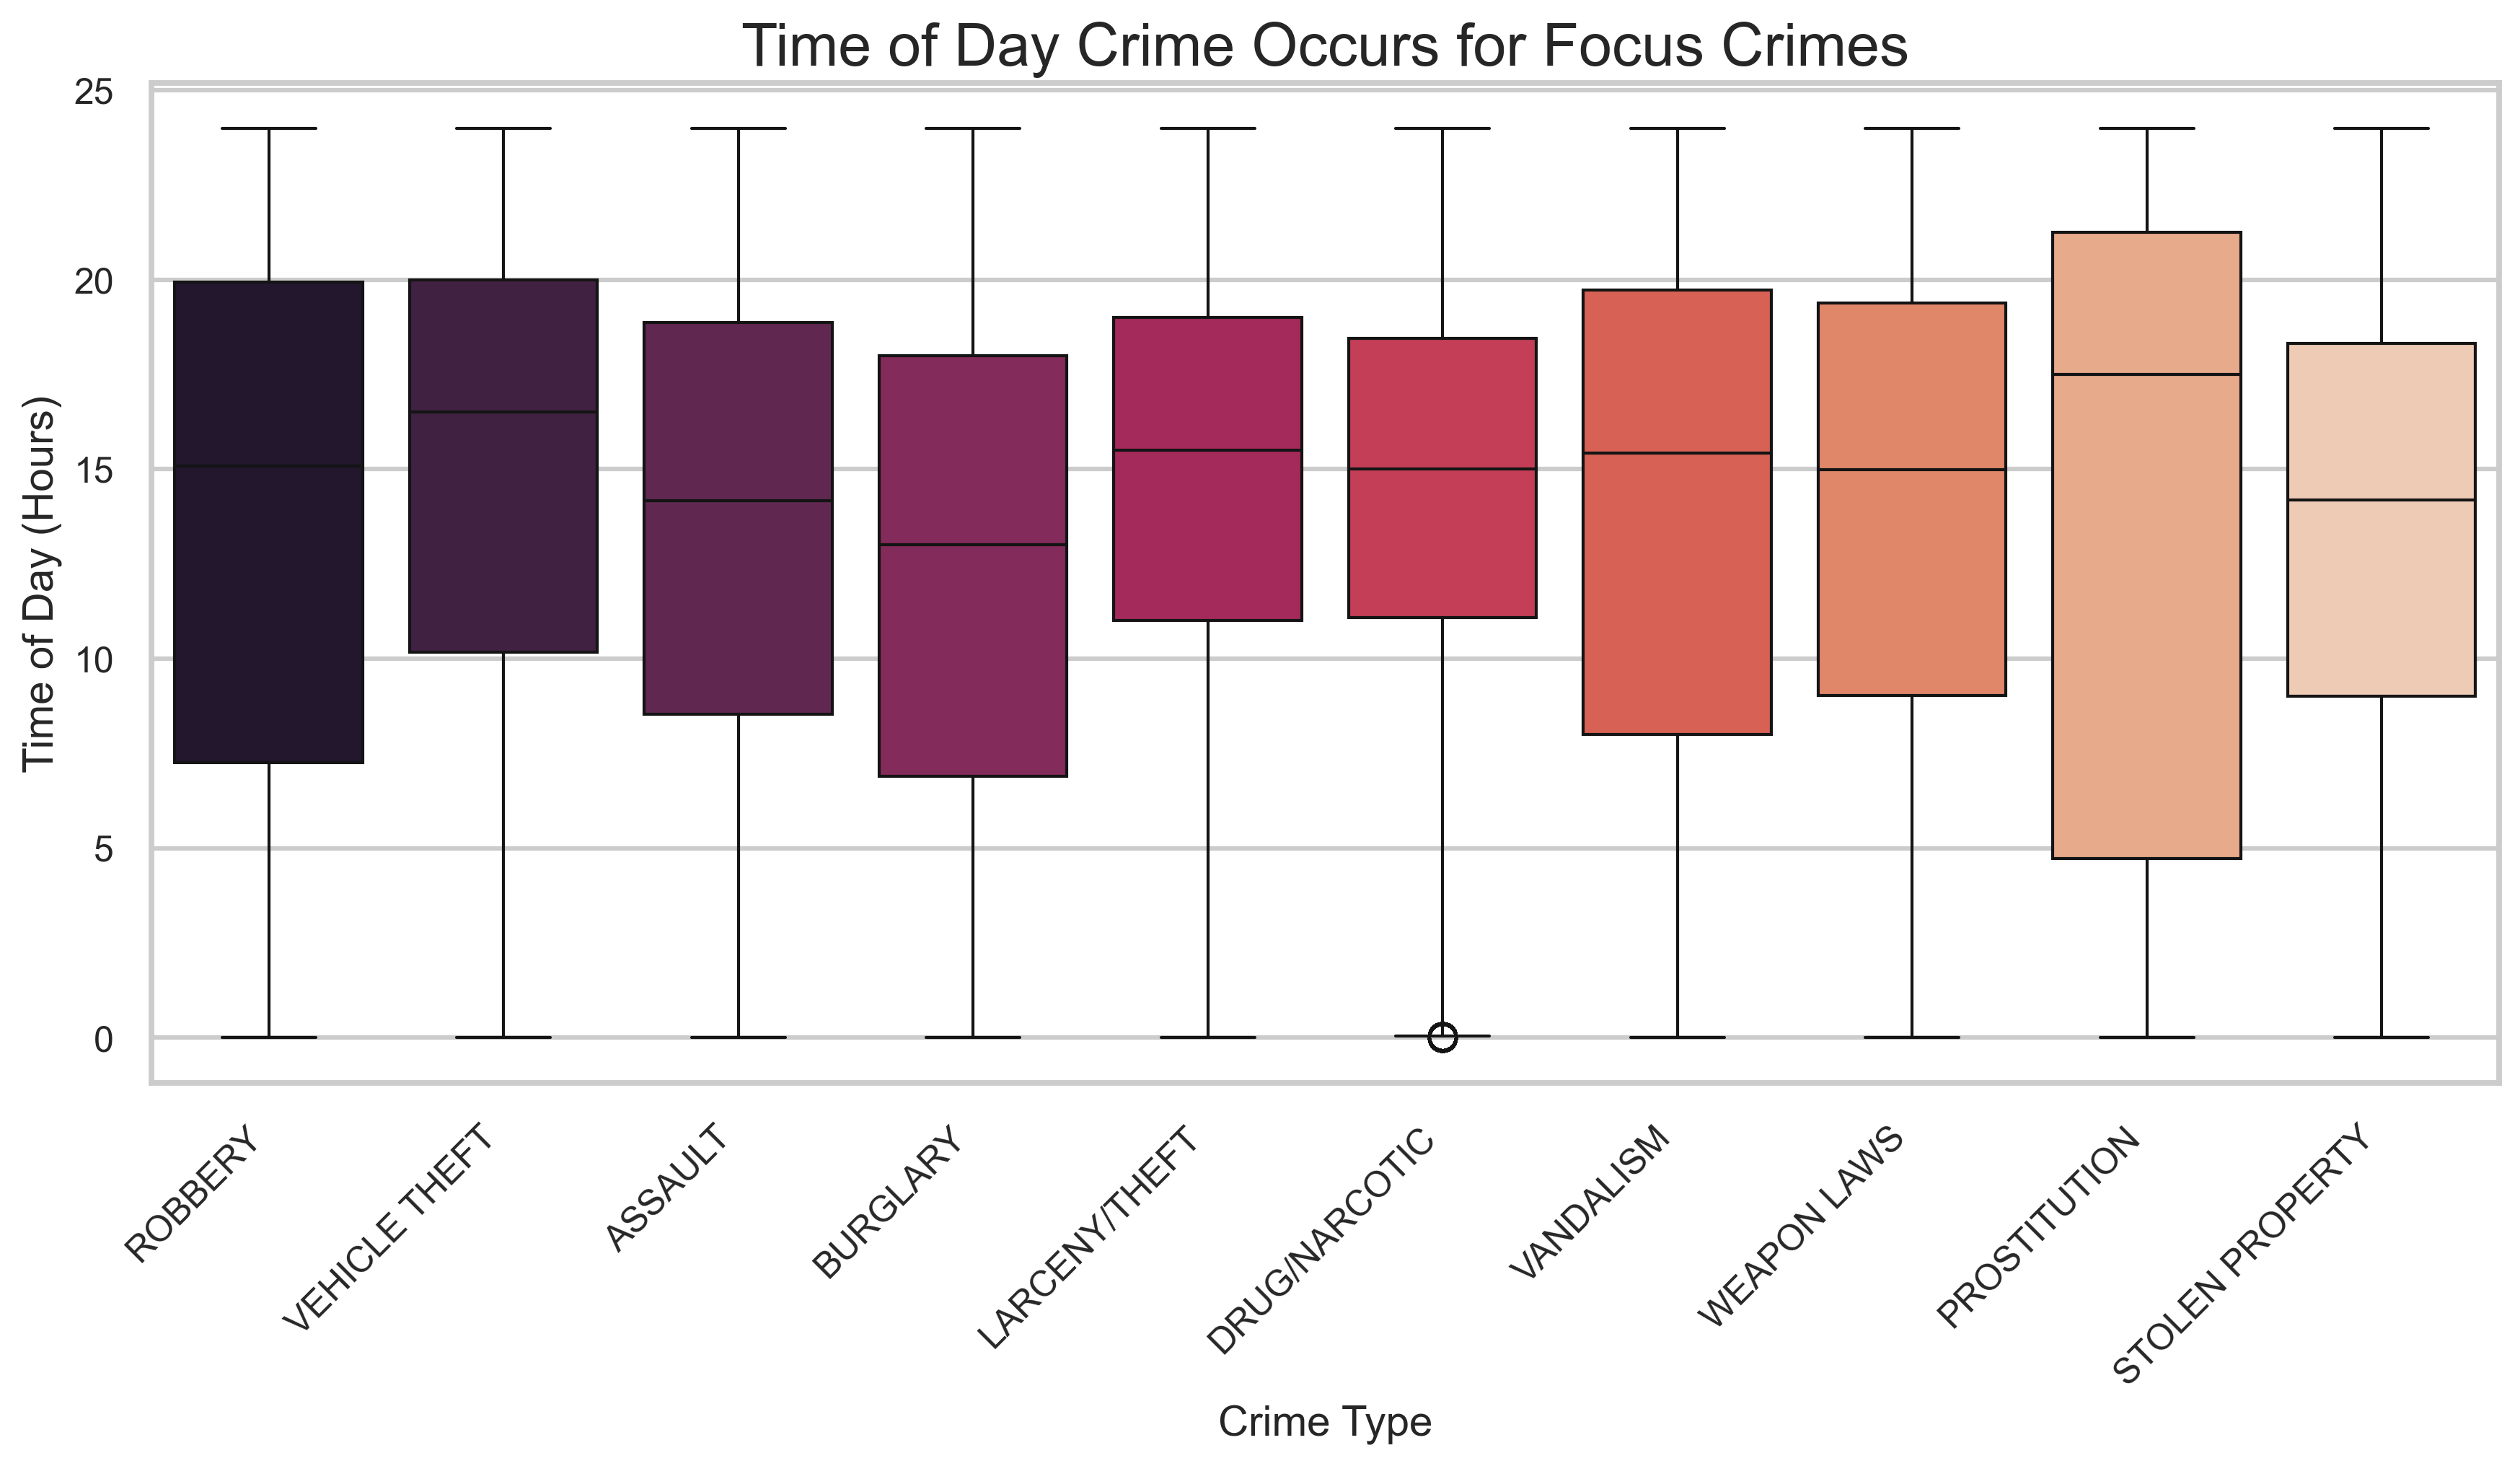

In [12]:
# now we do the next bit yay!!

# Convert 'incident time' to hour-based float representation (Option 2: Hour + minute percentage)
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M")
df["hour_float"] = df["Time"].dt.hour + df["Time"].dt.minute / 60

# Filter for focus crimes
time_focus_crimes = df[df["Category"].isin(focuscrimes)][["Category", "hour_float"]]

plt.figure(figsize=(14, 6))

sns.boxplot(data=time_focus_crimes, x="Category", y="hour_float", hue="Category", palette=sns.color_palette("rocket", len(focuscrimes)), dodge=False)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Crime Type")
plt.ylabel("Time of Day (Hours)")
plt.title("Time of Day Crime Occurs for Focus Crimes")

plt.show()